In [867]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import matplotlib.pyplot as plt
import requests
import time
from keras.models import load_model

In [868]:
model = load_model('../models/model.keras')
#Read test data
use_model_data = True
price_column = "Price"
df = pd.read_csv('./prices.log', header=None, names=["Price", "Timestamp"])
if use_model_data:
    df = pd.read_csv('../recent_eth_prices.csv')
    price_column = "price"

prices = np.array(df[price_column]).reshape(-1, 1)

In [869]:
#Set min-max scaler to same as model
model_data = pd.read_csv('../resampled_data.csv')
model_prices = np.array(model_data['price'])

# Load the same MinMaxScaler used during training
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaler.fit(model_prices.reshape(-1, 1))  # Fit on the current live prices

MinMaxScaler()

In [870]:
#read test data
df.head()
#sample every x minute
minute = 1
df = df.iloc[::minute]
df.head()

,Unnamed: 0,trade_id,product_id,price,size,time,side,bid,ask,exchange
0,0,415091890,ETH-USD,1791.70,0.077150,2025-04-23 04:15:08.734000+00:00,BUY,NaN,NaN,NaN
1,1,636546977,ETH-USD,1790.86,0.002936,2025-04-23 04:16:09.805374+00:00,SELL,NaN,NaN,NaN
2,2,636547232,ETH-USD,1791.16,0.027637,2025-04-23 04:17:09.491043+00:00,SELL,NaN,NaN,NaN
3,3,636547500,ETH-USD,1789.37,0.004180,2025-04-23 04:18:09.703932+00:00,SELL,NaN,NaN,NaN
4,4,636547743,ETH-USD,1786.65,0.000022,2025-04-23 04:19:10.897216+00:00,SELL,NaN,NaN,NaN


In [871]:
# Scale prices to match training format
prices_original = df[price_column].values.reshape(-1, 1)
df['transformed_price'] = scaler.transform(prices_original)
df['sma_5'] = df['transformed_price'].rolling(window=5).mean()
df['momentum'] = df['transformed_price'] - df['transformed_price'].shift(5)
df['price_scaled'] = scaler.fit_transform(df[[price_column]])
df['pct_change'] = df[price_column].pct_change() * 100  # Convert to percentage
df.dropna(subset=['sma_5', 'momentum'], inplace=True)
df.head()

prices = df['price_scaled'].values
sma_5 = df['sma_5'].values
momentum = df['momentum'].values

In [881]:
# Prepare the data for LSTM (same sequence length used in training)
X_test = []

# Create sequences of data for LSTM
sequence_length = 15  # Sequence of 10 observations
forecast_steps = 30  # Predict 5 steps into the future

for i in range(0, len((prices) - sequence_length - forecast_steps), sequence_length):
    try:
        #build feature set
        row = []
        row.append(np.array(prices[i:i + sequence_length]).reshape(sequence_length, 1))
        #row.append(np.array(sma_5[i:i + sequence_length]).reshape(sequence_length, 1))
        #row.append(np.array(momentum[i:i + sequence_length]).reshape(sequence_length, 1))

        X_test.append(prices[i:i + sequence_length])
    except ValueError:
        break

X_test = np.array(X_test)

In [873]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get actual price values
predicted_prices = scaler.inverse_transform(predictions)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [874]:
len(predictions)

527

In [889]:
#pull real prices to compare with predictions
prices_to_compare = []
step_length = forecast_steps
for i in range(sequence_length + step_length - 1, len(prices), sequence_length):
    prices_to_compare.append(prices_original[i])

len(prices_to_compare)
predicted_prices = predicted_prices[2:]

In [893]:
prices_to_compare

525

In [876]:
def print_percent_diff(A, B):
    # Compute % difference for each element
    percent_diff = np.abs(A - B) / ((A + B) / 2) * 100

    # Compute and print the average percentage difference
    average_percent_diff = np.mean(percent_diff)
    print("Average Percentage Difference: " + str(average_percent_diff) + "%")

In [877]:
print_percent_diff(predicted_prices, prices_to_compare)

Average Percentage Difference: 0.06825585763113978%


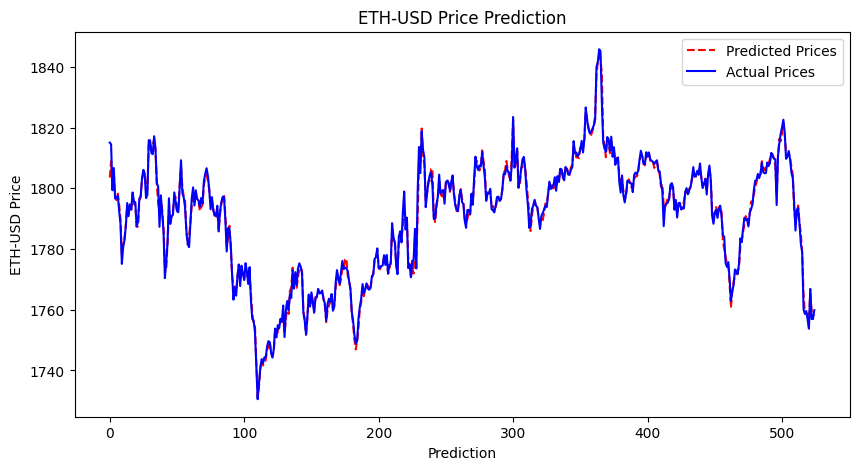

In [878]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(predicted_prices, label="Predicted Prices", color="red", linestyle="dashed")
plt.plot(prices_to_compare, label="Actual Prices", color="blue")
plt.xlabel("Prediction")
plt.ylabel("ETH-USD Price")
plt.legend()
plt.title("ETH-USD Price Prediction")
plt.show()

In [879]:
correct_buy_predictions = 0
incorrect_buy_predictions = 0
correct_sell_predictions = 0
incorrect_sell_predictions = 0
total_trades = 0
threshold = 0.01 # don't take action unless prediction is at lest threshold % away
max_sell_pct = 0
max_buy_pct = 0
last = 0

for i in range(len(predicted_prices) ):
    if last == 0:
        last = prices_to_compare[i]
        continue

    # Real price of ETH
    real_price = prices_to_compare[i]
    #Predicted price of ETH
    predicted_price = predicted_prices[i]

    pct_change = (predicted_price - last)/last
    if abs(pct_change) < threshold:
        continue    

    if pct_change < max_sell_pct:
        max_sell_pct = pct_change

    if pct_change > max_buy_pct:
        max_buy_pct = pct_change

    total_trades += 1
    #Check if both prediction and real price were up or down
    if (real_price - last > 0 and predicted_price - last > 0):
        correct_buy_predictions += 1
    elif( real_price - last < 0 and predicted_price - last > 0):
        incorrect_buy_predictions += 1
    elif (real_price - last < 0 and predicted_price - last < 0):
        correct_sell_predictions += 1
    elif (real_price - last > 0 and predicted_price - last < 0):
        incorrect_sell_predictions += 1

if correct_sell_predictions + incorrect_sell_predictions > 0:
    print(f"SELL Predictions: {correct_sell_predictions + incorrect_sell_predictions}, Correct: {correct_sell_predictions}, Incorrect: {incorrect_sell_predictions}, Correct Rate: {(correct_sell_predictions/(correct_sell_predictions + incorrect_sell_predictions) * 100)}%")
if correct_buy_predictions + incorrect_buy_predictions > 0:
    print(f"BUY Predictions: {correct_buy_predictions + incorrect_buy_predictions}, Correct: {correct_buy_predictions}, Incorrect: {incorrect_buy_predictions}, Correct Rate: {(correct_buy_predictions/(correct_buy_predictions + incorrect_buy_predictions) * 100)}%")
total_correct = correct_buy_predictions + correct_sell_predictions
total_incorrect = incorrect_buy_predictions + incorrect_sell_predictions
if correct_buy_predictions + incorrect_buy_predictions + correct_sell_predictions + incorrect_sell_predictions:
    print(f"Overall correct rate: {(total_correct/total_trades)*100}%")

print(f"Max Buy ROC: {max_buy_pct * 100}%")
print(f"Max Sell ROC: {max_sell_pct * 100}%")
print(f"Trade Rate: {(total_correct/len(predicted_prices))*100}%")


SELL Predictions: 295, Correct: 295, Incorrect: 0, Correct Rate: 100.0%
BUY Predictions: 5, Correct: 5, Incorrect: 0, Correct Rate: 100.0%
Overall correct rate: 100.0%
Max Buy ROC: [1.57396158]%
Max Sell ROC: [-4.61737548]%
Trade Rate: 57.14285714285714%


In [880]:
print(f"--------Model Information--------\r\nInterval: {minute * 60} seconds\r\nsequence_length: {sequence_length}\r\nforecast_steps: {forecast_steps}")

--------Model Information--------
Interval: 60 seconds
sequence_length: 15
forecast_steps: 30
